In [48]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [37]:
def fetch_dota2_matches_less_than(less_than_match_id, limit=100):
    """
    Fetch matches using less_than_match_id from the OpenDota API.
    """
    url = f"https://api.opendota.com/api/proMatches?less_than_match_id={less_than_match_id}&limit={limit}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch matches: {response.status_code}")
        return []

In [38]:
less_than_match_id = 8063200834  # Example ID
matches = fetch_dota2_matches_less_than(less_than_match_id, limit=200)  # Fetch 200 matches


In [39]:
matches

[{'match_id': 8063176161,
  'duration': 1826,
  'start_time': 1733079671,
  'radiant_team_id': 9381678,
  'radiant_name': 'Apex Genesis',
  'dire_team_id': 8697185,
  'dire_name': 'Fantasy Gaming',
  'leagueid': 17367,
  'league_name': 'EPL World Series: America 2024-2025 Season ',
  'series_id': 931242,
  'series_type': 1,
  'radiant_score': 19,
  'dire_score': 34,
  'radiant_win': False,
  'version': 21},
 {'match_id': 8063086548,
  'duration': 2002,
  'start_time': 1733076235,
  'radiant_team_id': 8697185,
  'radiant_name': 'Fantasy Gaming',
  'dire_team_id': 9381678,
  'dire_name': 'Apex Genesis',
  'leagueid': 17367,
  'league_name': 'EPL World Series: America 2024-2025 Season ',
  'series_id': 931242,
  'series_type': 1,
  'radiant_score': 13,
  'dire_score': 47,
  'radiant_win': False,
  'version': 21},
 {'match_id': 8063069899,
  'duration': 3367,
  'start_time': 1733076211,
  'radiant_team_id': 8291895,
  'radiant_name': 'Tundra Esports',
  'dire_team_id': 8255888,
  'dire_nam

In [41]:
def preprocess_matches(matches):
    """
    Preprocess matches into a DataFrame with relevant features.
    """
    records = []
    for match in matches:
        try:
            # Extract match details
            radiant_win = int(match['radiant_win'])
            radiant_gold = match.get('radiant_gold_advantage', 0) or 0
            dire_gold = -radiant_gold
            radiant_xp = match.get('radiant_xp_advantage', 0) or 0
            dire_xp = -radiant_xp
            radiant_heroes = match['radiant_team'] if 'radiant_team' in match else [0] * 5
            dire_heroes = match['dire_team'] if 'dire_team' in match else [0] * 5
            
            # Record structured data
            records.append({
                "radiant_win": radiant_win,
                "radiant_gold": radiant_gold,
                "dire_gold": dire_gold,
                "radiant_xp": radiant_xp,
                "dire_xp": dire_xp,
                **{f"radiant_hero_{i}": radiant_heroes[i] if i < len(radiant_heroes) else 0 for i in range(5)},
                **{f"dire_hero_{i}": dire_heroes[i] if i < len(dire_heroes) else 0 for i in range(5)},
            })
        except KeyError:
            continue  # Skip invalid or incomplete matches
    return pd.DataFrame(records)

In [42]:
df = preprocess_matches(matches)

In [43]:
df = pd.get_dummies(df, columns=[f"radiant_hero_{i}" for i in range(5)] + [f"dire_hero_{i}" for i in range(5)])


In [44]:
X = df.drop(columns=["radiant_win"])
y = df["radiant_win"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X_train, y_train)

C:\Users\Vashist\PycharmProjects\Portfolio Projects\lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [46]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



C:\Users\Vashist\PycharmProjects\Portfolio Projects\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vashist\PycharmProjects\Portfolio Projects\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vashist\PycharmProjects\Portfolio Projects\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

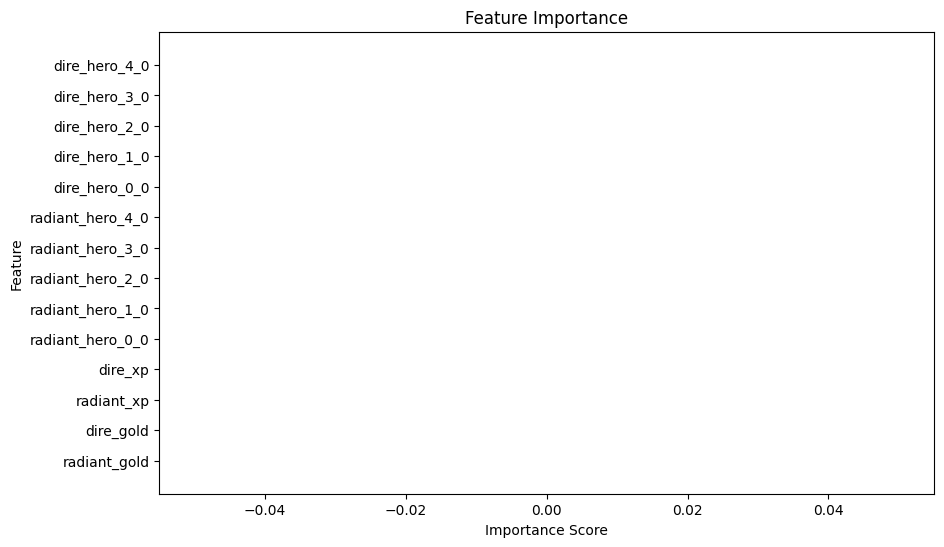

In [47]:
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()